In [29]:
import os
import torch
import torchvision
from torchvision.datasets import CIFAR10
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

In [30]:
#root='/Users/dl'
root='data/'

dataset = CIFAR10(root, download=True, transform=ToTensor())
test = CIFAR10(root, train=False, transform=ToTensor())
classes = dataset.classes    # get labels

batch_size=128
train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test, batch_size, num_workers=4, pin_memory=True)


Files already downloaded and verified


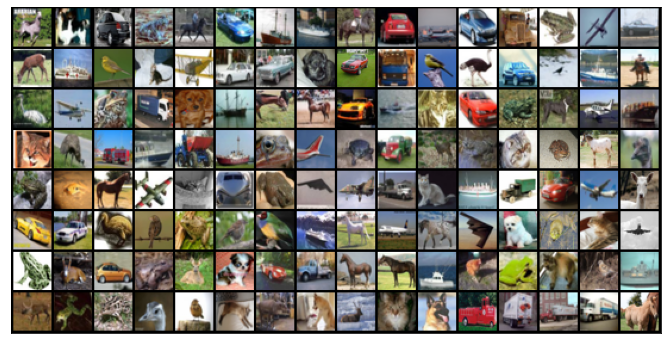

In [31]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [32]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    
device = get_default_device()
device

device(type='cuda')

In [33]:
import torch.nn as nn
import torch.nn.functional as F


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'train_loss': loss.detach(), 'test_acc': acc}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']))



In [34]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=11,padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64,128, kernel_size=3,padding=0),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size=3,padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2,2), 
            nn.Flatten(), 
            nn.Linear(128*4*4, 10))

        
    def forward(self, xb):
        return self.network(xb)
    

In [35]:

class BatchNorm_Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=11,padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),         
            nn.Conv2d(64,128, kernel_size=3,padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size=3,padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2,2), 
            nn.Flatten(), 
            nn.Linear(128*4*4, 10))

        
    def forward(self, xb):
        return self.network(xb)



In [36]:
## new design model
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class MyNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
         #iput 3x32x32
        self.conv1 = conv_block(3, 64) #64x32x32
        self.conv2 = conv_block(64, 128, pool=True)#128x16x16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))#128x16x16
        
        self.conv3 = conv_block(128, 256, pool=True)#256x8x8
        self.conv4 = conv_block(256, 512, pool=True)#512X4x4
        #self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))#512x4x4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), #512x1x1
                                        nn.Flatten(), #512
                                        nn.Linear(512, 10))#10 output
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        #out = self.res2(out) + out
        out = self.classifier(out)
        return out



In [37]:
#model = Cifar10CnnModel()
#model=BatchNorm_Model()
model=MyNet()
model

MyNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

MyNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True

In [39]:
def evaluate(model, test_loader):
    # return test loss and test acc
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

In [40]:
def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Test  phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [41]:
def fit2(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    
    optimizer = opt_func(model.parameters(), lr)
    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        scheduler.step()
        
        # Test  phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
#model = to_device(Cifar10CnnModel(), device)
#model = to_device(BatchNorm_Model(), device)
model = to_device(MyNet(), device)

evaluate(model, test_dl)

{'test_loss': 2.304471731185913, 'test_acc': 0.09918908029794693}

In [44]:
from torch.optim import lr_scheduler
num_epochs = 2
opt_func = torch.optim.Adam
lr = 1e-3

history = fit2(num_epochs, lr, model, train_dl, test_dl, opt_func)



Epoch [0], train_loss: 0.6553, test_loss: 0.7125, test_acc: 0.7497
Epoch [1], train_loss: 0.4506, test_loss: 0.5628, test_acc: 0.8123


In [ ]:
###.  waiting  results

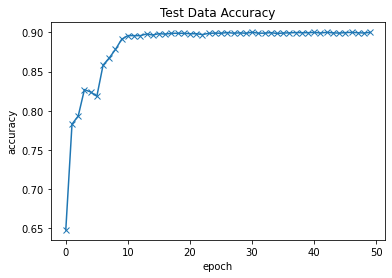

In [19]:
def plot_accuracies(history):
    accuracies = [x['test_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Test Data Accuracy');

plot_accuracies(history)

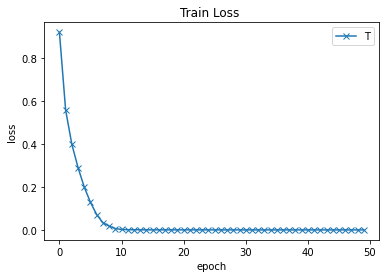

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    #test_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, '-x')
    #plt.plot(test_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend('Training')
    #plt.legend(['Training', 'Test'])
    plt.title('Train Loss ');
plot_losses(history)

In [21]:
filters = model.modules


In [26]:
#show filters
def plot_kernels(tensor, num_cols=16):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    #num_rows = 1+ num_kernels // num_cols
    num_rows =4
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

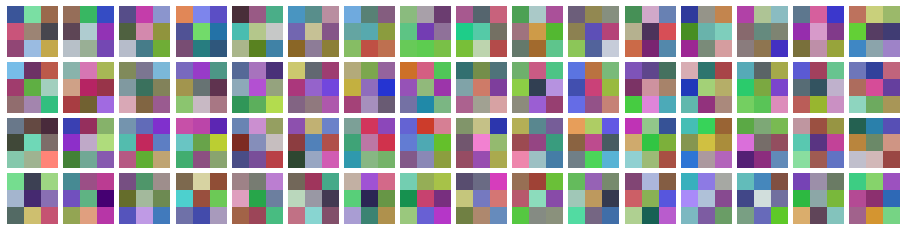

In [27]:
#get weights 
body_model = [i for i in model.children()][0]
layer1 = body_model[0]
tensor = layer1.weight.data.cpu().numpy()
tensor=tensor.transpose((0, 2, 3, 1))

# normalize filter values 
filters = (tensor - tensor.min()) / (tensor - tensor.min()).max()
plot_kernels(filters)